In [1]:


import os
os.chdir('/home/BCCRC.CA/ssubedi/projects/experiments/asapp')

from asap.util.io import read_config
from collections import namedtuple
from pathlib import Path
import pandas as pd
import numpy as np
from asap.data.dataloader import DataSet
from asap.util import topics

import matplotlib.pylab as plt
import seaborn as sns
import colorcet as cc


experiment = '/projects/experiments/asapp/'
server = Path.home().as_posix()
experiment_home = server+experiment
experiment_config = read_config(experiment_home+'config.yaml')
args = namedtuple('Struct',experiment_config.keys())(*experiment_config.values())

sample_in = args.home + args.experiment + args.input+ args.sample_id +'/'+args.sample_id
sample_out = args.home + args.experiment + args.output+ args.sample_id +'/'+args.sample_id

dl = DataSet('pbmc',sample_in,sample_out)
dl.config = args
dl.initialize_data()
print(dl.inpath)
print(dl.outpath)


/home/BCCRC.CA/ssubedi/projects/experiments/asapp/data/pbmc3k/pbmc3k
/home/BCCRC.CA/ssubedi/projects/experiments/asapp/result/pbmc3k/pbmc3k


In [2]:
model = np.load(sample_out+'_dcnmf.npz')

In [ ]:
df_beta.shape

In [3]:
df_beta = pd.DataFrame(model['beta'].T)
df_beta.columns = ['gene_'+str(x) for x in range(len(dl.genes))]
df_theta = pd.DataFrame(model['corr'])
df_theta.index = dl.barcodes

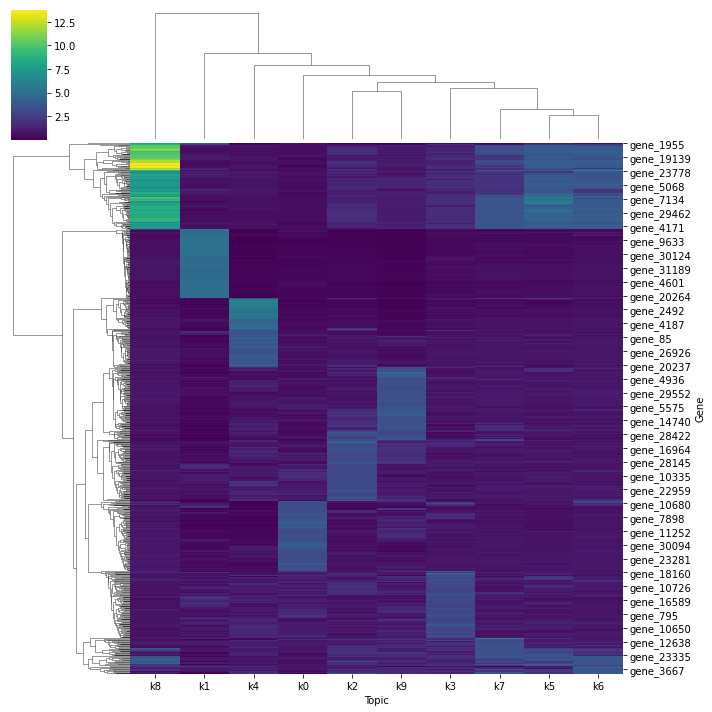

In [4]:
df_top = topics.get_topic_top_genes(df_beta.iloc[:,:],top_n=100)
df_top = df_top.pivot(index='Topic',columns='Gene',values='Proportion')
# df_top[df_top>20] = 20
sns.clustermap(df_top.T,cmap='viridis')

In [5]:
import umap
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df_umap= pd.DataFrame()
df_umap['cell'] = dl.barcodes
# df_umap['topic_bulk'] = [x for x in df_theta.iloc[:,:].idxmax(axis=1)]

scaler = StandardScaler()
scaled = scaler.fit_transform(df_theta.to_numpy())
kmeans = KMeans(n_clusters=10, init='k-means++',random_state=0).fit(scaled)
df_umap['topic_bulk'] = kmeans.labels_

umap_2d = umap.UMAP(n_components=2, init='random', random_state=0,min_dist=0.4,metric='cosine')
proj_2d = umap_2d.fit(df_theta.iloc[:,1:])
df_umap[['umap1','umap2']] = umap_2d.embedding_[:,[0,1]]
df_umap

# df_umap = pd.read_csv(sample_out+'_theta_umap.csv')
# df_umap.columns = ['cell','umap1','umap2']


,cell,topic_bulk,umap1,umap2
0,AAACATACAACCAC-1,5,1.677371,1.385625
1,AAACATTGAGCTAC-1,9,6.686853,13.856432
2,AAACATTGATCAGC-1,0,0.283639,5.225554
3,AAACCGTGCTTCCG-1,8,13.496946,4.127341
4,AAACCGTGTATGCG-1,2,-6.382128,4.265769
...,...,...,...,...
2695,TTTCGAACTCTCAT-1,1,12.873358,1.316887
2696,TTTCTACTGAGGCA-1,3,1.400779,5.060194
2697,TTTCTACTTCCTCG-1,9,8.606114,15.247340
2698,TTTGCATGAGAGGC-1,9,9.216572,14.772552


Text(0, 0.5, 'UMAP2')

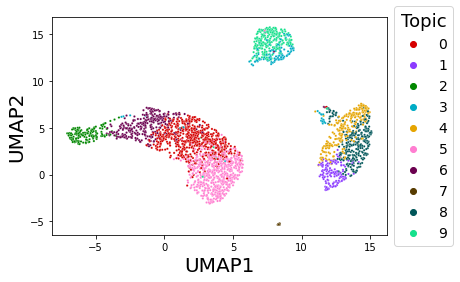

In [6]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['topic_bulk'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='topic_bulk',s=5,palette=cp,legend=True)
plt.legend(title='Topic',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))
# p.axes.set_title("topics from bulkNMF",fontsize=30)
p.set_xlabel("UMAP1",fontsize=20)
p.set_ylabel("UMAP2",fontsize=20)

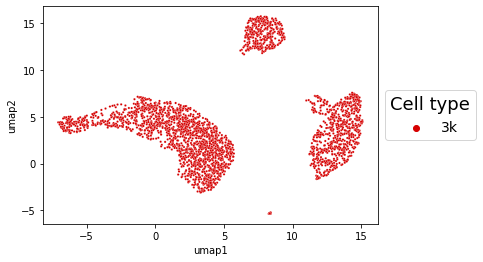

In [8]:
dl.add_batch_label(['3k' for i in range(len(dl.barcodes))])
df_umap['batch'] = dl.batch_label
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['batch'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='batch',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [10]:
df_pl = pd.read_csv(dl.outpath+'_scanpy.csv.gz')
# df_pl = df_pl[['cell','leiden']]
# df_pl = df_pl.loc[:,['Unnamed: 0','celltype_major']]
df_pl.columns = ['cell','cell_type']
df_pl['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap['cell'] = [x.split('_')[0] for x in df_umap['cell']]
df_umap = pd.merge(df_umap,df_pl[['cell','cell_type']],on='cell',how='left')
df_umap

,cell,topic_bulk,umap1,umap2,batch,cell_type
0,AAACATACAACCAC-1,5,1.677371,1.385625,3k,0
1,AAACATTGAGCTAC-1,9,6.686853,13.856432,3k,3
2,AAACATTGATCAGC-1,0,0.283639,5.225554,3k,0
3,AAACCGTGCTTCCG-1,8,13.496946,4.127341,3k,1
4,AAACCGTGTATGCG-1,2,-6.382128,4.265769,3k,2
...,...,...,...,...,...,...
2695,TTTCGAACTCTCAT-1,1,12.873358,1.316887,3k,1
2696,TTTCTACTGAGGCA-1,3,1.400779,5.060194,3k,3
2697,TTTCTACTTCCTCG-1,9,8.606114,15.247340,3k,3
2698,TTTGCATGAGAGGC-1,9,9.216572,14.772552,3k,3


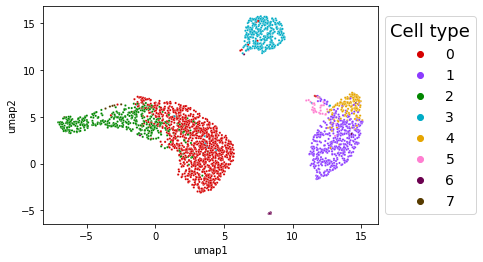

In [11]:
cp = sns.color_palette(cc.glasbey_dark, n_colors=len(df_umap['cell_type'].unique()))
p = sns.scatterplot(data=df_umap, x='umap1', y='umap2', hue='cell_type',s=5,palette=cp,legend=True)
plt.legend(title='Cell type',title_fontsize=18, fontsize=14,loc='center left', bbox_to_anchor=(1, 0.5))

In [12]:
df_match = df_umap[['cell','cell_type','topic_bulk']]
df_match = df_match.groupby(['cell_type','topic_bulk']).count().reset_index()
df_match = df_match.pivot('cell_type','topic_bulk')
df_match = df_match.fillna(0)
df_match

cell                                                         \
topic_bulk      0      1      2      3      4      5      6     7      8   
cell_type                                                                  
0           501.0    0.0    0.0    2.0    0.0  594.0   90.0   0.0    0.0   
1             1.0  152.0    0.0    0.0  116.0    0.0    0.0   0.0  223.0   
2           105.0    0.0  142.0    0.0    0.0   13.0  194.0   0.0    0.0   
3             2.0    0.0    0.0  100.0    1.0    1.0    1.0   0.0    0.0   
4             0.0    0.0    0.0    0.0  115.0    0.0    0.0   0.0   38.0   
5             0.0    0.0    0.0   16.0    8.0    0.0    0.0   0.0   10.0   
6             0.0    0.0    0.0    1.0    1.0    0.0    1.0  12.0    1.0   
7             0.0    0.0    3.0    5.0    0.0    0.0    0.0   0.0    0.0   

                   
topic_bulk      9  
cell_type          
0             6.0  
1             1.0  
2             0.0  
3           243.0  
4             0.0  
5             1.0  
6             0.0  
7             0.0

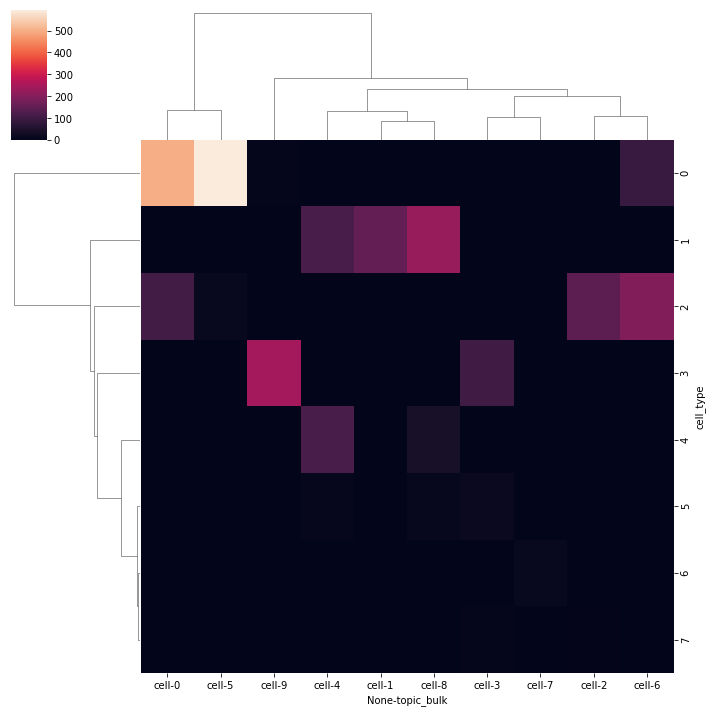

In [13]:
sns.clustermap(df_match)

In [ ]:
df_umap

In [14]:
from sklearn.metrics import normalized_mutual_info_score

normalized_mutual_info_score(df_umap['cell_type'].values,df_umap['topic_bulk'].values)

0.6212623596027049